# Setup


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install tabulate

In [ ]:
%cd /content/drive/MyDrive/Adverserial Attack


/content/drive/MyDrive/Adverserial Attack


In [ ]:
!pip install -r requirements.txt


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=e9849eee6eab8fc415179037d61b009392cd4b410436a2a899cf8be225153fd7
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [ ]:


!pip install -q transformers datasets sentence-transformers rouge-score nltk editdistance
##NLTK, which stands for Natural Language Toolkit, is a widely used, open-source Python library designed for working with human language data.
import random, os, math, time
random.seed(42)

from datasets import load_dataset
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from sentence_transformers import SentenceTransformer, util
import editdistance
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab', quiet=True)

nltk.download("averaged_perceptron_tagger_eng")


nltk.download("averaged_perceptron_tagger", quiet=True)
import torch
import logging
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


# Word Level


In [ ]:
import subprocess, pandas as pd
from pathlib import Path
from tabulate import tabulate

import subprocess, pandas as pd
from pathlib import Path
from tabulate import tabulate

#models = ["t5-small","bart"]
#word_specs = ["word:synonym", "word:delete","word:homoglyph"]
#
#for model in models:
#    out_dir = Path(f"artifacts/{model}_word")
#    out_dir.mkdir(parents=True, exist_ok=True)
#    cmd = [
#    "python", "-m", "src.pipeline",
#    "--dataset", "cnn_dailymail",
#    "--split", "test[:200]",
#    "--model", model,
#    "--perturbations", *word_specs,
#    "--success-drop", "0.02",
#    "--output-dir", str(out_dir),
#    "--seed", "42",
#]
#
#    subprocess.run(cmd, check=True)
#
word_df = pd.concat(pd.read_csv(Path(f"artifacts/{m}_word/metrics.csv")) for m in models)
word_attack_table = (
    word_df.groupby(["dataset", "model", "perturb"])["success"]
    .mean().mul(100).round(2)
    .reset_index()
    .pivot(index=["dataset", "model"], columns="perturb", values="success")
)
print("Word-level attack success for t5, bart, sample 200 (%)") #rename the model here
print(tabulate(word_attack_table.fillna(0), headers="keys", tablefmt="github"))

output_csv = Path("word_attack_table_t5_bart_200.csv")#rename the model here
word_attack_table.to_csv(output_csv)

print(f"\nSaved CSV to: {output_csv.resolve()}")








Word-level attack success for t5, bart, sample 200 (%)
|                               |   word:delete |   word:homoglyph |   word:synonym |
|-------------------------------|---------------|------------------|----------------|
| ('cnn_dailymail', 'bart')     |          20.5 |             22.5 |           16.5 |
| ('cnn_dailymail', 't5-small') |          14   |             21.5 |           17   |

Saved CSV to: /content/drive/MyDrive/Adverserial Attack/word_attack_table_t5_bart_200.csv


In [ ]:

word_df = pd.concat(pd.read_csv(Path(f"artifacts/{m}_word/metrics.csv")) for m in models)

metric_cols = ["r1_before", "r1_after", "sim_orig_adv", "changed_rate", "queries"]

per_model_metrics = (
    word_df.groupby(["dataset", "model", "perturb"])[metric_cols]
           .mean()
           .round(4)
           .rename(columns={
               "r1_before": "rouge before",
               "r1_after": "rouge after",
               "sim_orig_adv": "semantic similarity",
               "changed_rate": "changed rate",
               "queries": "avg queries",
           })
           .reset_index()
)

print("\nWord-level metrics (averages per model/attack)")
print(per_model_metrics.to_markdown(index=False))

per_model_metrics.to_csv("word_metrics_t5_bart_200.csv", index=False)
print("Saved metric table to word_metrics_t5_bart_200.csv")



Word-level metrics (averages per model/attack)
| dataset       | model    | perturb        |   rouge before |   rouge after |   semantic similarity |   changed rate |   avg queries |
|:--------------|:---------|:---------------|---------------:|--------------:|----------------------:|---------------:|--------------:|
| cnn_dailymail | bart     | word:delete    |         0.1864 |        0.1843 |                0.9397 |         1.1749 |             2 |
| cnn_dailymail | bart     | word:homoglyph |         0.1864 |        0.1858 |                0.9231 |         1.5807 |             2 |
| cnn_dailymail | bart     | word:synonym   |         0.1864 |        0.1874 |                0.9486 |         1.0546 |             2 |
| cnn_dailymail | t5-small | word:delete    |         0.1834 |        0.1838 |                0.9213 |         1.1553 |             2 |
| cnn_dailymail | t5-small | word:homoglyph |         0.1834 |        0.1828 |                0.9046 |         1.3343 |             2 |


In [ ]:
##rename the model here

pivoted.to_csv("per_attack_word_metrics_t5_bart.csv")
print("Saved stacked metrics to per_attack_word_metrics_t5_bart .csv")


# Sentence Level


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

PARA_MODEL = "tuner007/pegasus_paraphrase"
tokenizer = AutoTokenizer.from_pretrained(PARA_MODEL)
model = AutoModelForSeq2SeqLM.from_pretrained(PARA_MODEL)
print("Paraphraser downloaded and ready.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Paraphraser downloaded and ready.


In [2]:
#import subprocess, pandas as pd
#from pathlib import Path
#from tabulate import tabulate
#
#models = ["t5-small"]
#sentence_specs = ["sentence:paraphrase","sentence:reorder","sentence:homoglyph"]
#
#for model in models:
#    out_dir = Path(f"artifacts/{model}_sentence")
#    out_dir.mkdir(parents=True, exist_ok=True)
#    cmd = [
#        "python", "-m", "src.pipeline",
#        "--dataset", "cnn_dailymail",
#        "--split", "test[:10]",
#        "--model", model,
#        "--perturbations", *sentence_specs,
#        "--success-drop", "0.02",
#        "--output-dir", str(out_dir),
#        "--seed", "42",
#    ]
#    subprocess.run(cmd, check=True)




In [ ]:


sentence_df = pd.concat(
    pd.read_csv(Path(f"artifacts/{m}_sentence/metrics.csv")) for m in models
)
sentence_attack_table = (
    sentence_df.groupby(["dataset", "model", "perturb"])["success"]
        .mean().mul(100).round(2)
        .reset_index()
        .pivot(index=["dataset", "model"], columns="perturb", values="success")
)
print("Sentence-level attack success pegasus,distil (%)")
print(tabulate(sentence_attack_table.fillna(0), headers="keys", tablefmt="github"))
output_csv = Path("Sentence_attack_table_t5_bart_200.csv")#rename the model here
sentence_attack_table.to_csv(output_csv)

print(f"\nSaved CSV to: {output_csv.resolve()}")

Sentence-level attack success pegasus,distil (%)
|                               |   sentence:homoglyph |   sentence:paraphrase |   sentence:reorder |
|-------------------------------|----------------------|-----------------------|--------------------|
| ('cnn_dailymail', 'bart')     |                   50 |                    32 |                 44 |
| ('cnn_dailymail', 't5-small') |                   35 |                    23 |                 42 |

Saved CSV to: /content/drive/MyDrive/Adverserial Attack/Sentence_attack_table_pegasys_dsitilbart_200.csv


In [ ]:
models = ["t5-small","bart"]
sentence_df = pd.concat(
    pd.read_csv(Path(f"artifacts/{m}_sentence/metrics.csv")) for m in models
)

# attack success (same as before)
sentence_attack_table = (
    sentence_df.groupby(["dataset", "model", "perturb"])["success"]
        .mean().mul(100).round(2)
        .reset_index()
        .pivot(index=["dataset", "model"], columns="perturb", values="success")
)
print("Sentence-level attack success (%)")
print(tabulate(sentence_attack_table.fillna(0), headers="keys", tablefmt="github"))

# per-metric averages
metric_cols = ["r1_before", "r1_after", "sim_orig_adv", "changed_rate", "queries"]

sentence_metrics = (
    sentence_df.groupby(["dataset", "model", "perturb"])[metric_cols]
        .mean()
        .round(4)
        .rename(columns={
            "r1_before": "rouge before",
            "r1_after": "rouge after",
            "sim_orig_adv": "semantic similarity",
            "changed_rate": "changed rate",
            "queries": "avg queries",
        })
        .reset_index()
)
print("\nSentence-level metrics (averages per model/attack)")
print(sentence_metrics.to_markdown(index=False))

sentence_attack_table.to_csv("sentence_attack_table.csv")
sentence_metrics.to_csv("sentence_level_metrics_t5_bart.csv", index=False)

Sentence-level attack success (%)
|                               |   sentence:homoglyph |   sentence:paraphrase |   sentence:reorder |
|-------------------------------|----------------------|-----------------------|--------------------|
| ('cnn_dailymail', 'bart')     |                   50 |                    32 |                 44 |
| ('cnn_dailymail', 't5-small') |                   35 |                    23 |                 42 |

Sentence-level metrics (averages per model/attack)
| dataset       | model    | perturb             |   rouge before |   rouge after |   semantic similarity |   changed rate |   avg queries |
|:--------------|:---------|:--------------------|---------------:|--------------:|----------------------:|---------------:|--------------:|
| cnn_dailymail | bart     | sentence:homoglyph  |         0.168  |        0.1723 |                0.8094 |         2.89   |             2 |
| cnn_dailymail | bart     | sentence:paraphrase |         0.168  |        0.1751 |

In [ ]:
from pathlib import Path

# --- merge all metrics.csv files across models
metrics_paths = sorted(Path("artifacts").glob("*_sentence/metrics.csv"))
if not metrics_paths:
    raise FileNotFoundError("No metrics.csv files found—run step 1 first.")

frames = [pd.read_csv(path) for path in metrics_paths]
df = pd.concat(frames, ignore_index=True)

# --- add coarse-grained perturbation bucket
PERT_GROUP = {
    "NONE": "baseline",
    "orig": "baseline",
    "original": "baseline",
    "sentence:paraphrase": "sentence",
    "sentence:reorder": "sentence",
    "sentence:homoglyph": "sentence",
}
df["perturb_group"] = df["perturb"].map(PERT_GROUP).fillna("other")

# --- per-attack detail (same view as original table)
attack_table = (
    df.groupby(["dataset", "model", "perturb"])["success"]
      .mean().mul(100).round(2)
      .reset_index()
      .pivot(index=["dataset", "model"], columns="perturb", values="success")
      .reset_index()
)
print("\nAttack success per individual perturbation")
print(tabulate(attack_table.fillna(0), headers="keys", tablefmt="github", showindex=False))

# --- attack success rate per model/perturbation (values in %)
asr = (
    df.groupby(["dataset", "model", "perturb"])["success"]
      .mean().reset_index()
      .assign(attack_success_pct=lambda d: (d["success"] * 100).round(2))
      .drop(columns="success")
      .pivot(index=["dataset", "model"], columns="perturb", values="attack_success_pct")
      .reset_index()
)
print("\nAttack success rate (%) per model/perturbation")
print(asr.to_markdown(index=False))

# --- supporting metrics + per-model averages
support = (
    df.groupby(["dataset", "model"])
      .agg(
          mean_r1_before=("r1_before", "mean"),
          mean_r1_after=("r1_after", "mean"),
          mean_sem_sim=("sim_orig_adv", "mean"),
          mean_changed_rate=("changed_rate", "mean"),
          mean_queries=("queries", "mean"),
      )
      .reset_index()
)
print("\nModel-level averages across all perturbations")
print(support.to_markdown(index=False))


Attack success per individual perturbation
| dataset       | model      |   sentence:homoglyph |   sentence:paraphrase |   sentence:reorder |
|---------------|------------|----------------------|-----------------------|--------------------|
| cnn_dailymail | bart       |                   60 |                    40 |                 60 |
| cnn_dailymail | distilbart |                   30 |                    60 |                 40 |
| cnn_dailymail | pegasus    |                   60 |                    40 |                 30 |
| cnn_dailymail | t5-small   |                   60 |                    40 |                 60 |

Attack success rate (%) per model/perturbation
| dataset       | model      |   sentence:homoglyph |   sentence:paraphrase |   sentence:reorder |
|:--------------|:-----------|---------------------:|----------------------:|-------------------:|
| cnn_dailymail | bart       |                   60 |                    40 |                 60 |
| cnn_dailymail |

In [ ]:
STAT_COLS = {
    "r1_before": "mean_r1_before",
    "r1_after": "mean_r1_after",
    "sim_orig_adv": "mean_sem_sim",
    "changed_rate": "mean_changed_rate",
    "queries": "mean_queries",
}

sentence_attacks = ["sentence:paraphrase","sentence:reorder","sentence:homoglyph"]

per_attack_metrics = (
    df[df["perturb"].isin(sentence_attacks)]
      .groupby(["dataset", "model", "perturb"])
      .agg({col: "mean" for col in STAT_COLS})
      .rename(columns=STAT_COLS)
      .round(4)
      .reset_index()
)

pivoted = (
    per_attack_metrics.pivot(index=["dataset", "model"], columns="perturb")
      .sort_index(axis=1, level=0)
)

pivoted.to_csv("per_attack_sentence_metrics.csv")
print("Saved stacked metrics to per_attack_sentence_metrics.csv")


Saved stacked metrics to per_attack_sentence_metrics.csv


#Character Level


In [ ]:
import subprocess, pandas as pd
from pathlib import Path
from tabulate import tabulate

models = ["t5-small", "bart"]
char_specs = ["character:insert", "character:delete", "character:swap", "character:homoglyph"]

for model in models:
    out_dir = Path(f"artifacts/{model}_char")
    out_dir.mkdir(parents=True, exist_ok=True)
    cmd = [
        "python", "-m", "src.pipeline",
        "--dataset", "cnn_dailymail",
        "--split", "test[:200]",
        "--model", model,
        "--perturbations", *char_specs,
        "--success-drop", "0.02",
        "--output-dir", str(out_dir),
        "--seed", "42",
    ]
    subprocess.run(cmd, check=True)





In [ ]:


char_df = pd.concat(pd.read_csv(Path(f"artifacts/{m}_char/metrics.csv")) for m in models)
char_attack_table = (
    char_df.groupby(["dataset", "model", "perturb"])["success"]
        .mean().mul(100).round(2)
        .reset_index()
        .pivot(index=["dataset", "model"], columns="perturb", values="success")
)
print("Character-level attack success (%)")
print(tabulate(char_attack_table.fillna(0), headers="keys", tablefmt="github"))

print("Character attack success for t5, bart, sample 200 (%)") #rename the model here
print(tabulate(char_attack_table.fillna(0), headers="keys", tablefmt="github"))

output_csv = Path("char_attack_table_200.csv")#rename the model here
char_attack_table.to_csv(output_csv)

print(f"\nSaved CSV to: {output_csv.resolve()}")

In [ ]:
char_df = pd.concat(pd.read_csv(Path(f"artifacts/{m}_char/metrics.csv")) for m in models)


metric_cols = ["r1_before", "r1_after", "sim_orig_adv", "changed_rate", "queries"]

char_metrics = (
    char_df.groupby(["dataset", "model", "perturb"])[metric_cols]
           .mean()
           .round(4)
           .rename(columns={
               "r1_before": "rouge before",
               "r1_after": "rouge after",
               "sim_orig_adv": "semantic similarity",
               "changed_rate": "changed rate",
               "queries": "avg queries",
           })
           .reset_index()
)

print("\nCharacter-level metric averages")
print(char_metrics.to_markdown(index=False))

char_metrics.to_csv("char_metrics_t5_bart_200.csv", index=False)


# Cross Model Test



In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sentence_transformers import util

from src.models import MODEL_ALIASES, load_sentence_transformer  # reuse your alias + SBERT

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))



CUDA available: True
Device: NVIDIA A100-SXM4-80GB


In [ ]:
# Cache for loaded models
_model_cache = {}

def load_model_fast(model_name: str):
    """
    Load seq2seq model once, put it on GPU (FP16), cache it.
    Uses your MODEL_ALIASES mapping.
    """
    if model_name in _model_cache:
        return _model_cache[model_name]

    resolved = MODEL_ALIASES.get(model_name, model_name)
    print(f"Loading {model_name} → {resolved}")

    tokenizer = AutoTokenizer.from_pretrained(resolved)

    # Try FP16 on GPU, fallback to FP32 if needed
    try:
        model = AutoModelForSeq2SeqLM.from_pretrained(resolved).half().to("cuda")
    except Exception as e:
        print(f"FP16 failed for {resolved}, using FP32. Error: {e}")
        model = AutoModelForSeq2SeqLM.from_pretrained(resolved).to("cuda")

    model.eval()
    _model_cache[model_name] = (tokenizer, model)
    return tokenizer, model


@torch.inference_mode()
def batch_summarize(text_list, model_name: str, max_length: int = 150, min_length: int = 40):
    """
    Batched summarization on GPU.
    """
    tokenizer, model = load_model_fast(model_name)

    inputs = tokenizer(
        text_list,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=1024,
    ).to("cuda")

    outputs = model.generate(
        **inputs,
        max_length=max_length,
        min_length=min_length,
        num_beams=4,
        early_stopping=True,
    )

    return tokenizer.batch_decode(outputs, skip_special_tokens=True)


In [ ]:
# Load SBERT once and move to GPU if possible
embedder = load_sentence_transformer("default")
try:
    embedder = embedder.to("cuda")
    print("SBERT on GPU")
except Exception as e:
    print("Could not move SBERT to GPU, staying on CPU:", e)

def batch_similarity(clean_list, adv_list):
    """
    Compute cosine similarity between clean and adv summaries in batch.
    Returns a list of floats.
    """
    emb_clean = embedder.encode(clean_list, convert_to_tensor=True, batch_size=16)
    emb_adv   = embedder.encode(adv_list,   convert_to_tensor=True, batch_size=16)
    sims = util.cos_sim(emb_clean, emb_adv).diagonal().tolist()
    return sims


SBERT on GPU


In [ ]:
import re
from nltk import word_tokenize
from src.perturbations.word import identify_important_words, perturb
from src.nlp_utils import ensure_nltk_data

def generate_word_attack_exact(text: str, method: str, top_k: int = 10) -> str:

    ensure_nltk_data(["punkt", "stopwords"])

    tokens = word_tokenize(text)
    important = identify_important_words(text, top_n=top_k)
    important_set = {w.lower() for w in important}

    new_tokens = []
    for tok in tokens:
        if tok.lower() in important_set:
            new_tok = perturb(
                tok,
                method=method,
                original_text=text,
                generated_summary="",   # you weren't using summary-aware importance here
            )
            # keep exactly what perturb returns; delete() returns ""
            if new_tok is None:
                new_tok = ""
            new_tokens.append(new_tok)
        else:
            new_tokens.append(tok)

    # join and clean multiple spaces caused by deletes
    out = " ".join(t for t in new_tokens if t != "")
    out = re.sub(r"\s+", " ", out).strip()
    return out


In [ ]:
import pandas as pd
from pathlib import Path
from datasets import load_dataset

def create_transfer_perturbed_inputs(source_model: str, n_samples: int = 100):

    dataset = load_dataset("cnn_dailymail", "3.0.0", split=f"test[:{n_samples}]")

    outdir = Path(f"transfer_experiments/source_{source_model}")
    outdir.mkdir(parents=True, exist_ok=True)

    rows = []
    for item in dataset:
        text = item["article"]

        for method in ["synonym", "delete", "homoglyph"]:
            perturbed = generate_word_attack_exact(text, method=method, top_k=10)

            rows.append({
                "source_model": source_model,
                "perturb_type": f"word:{method}",
                "clean_text": text,
                "perturbed_text": perturbed,
            })

    df = pd.DataFrame(rows)
    df.to_csv(outdir / "perturbed.csv", index=False)
    print("Saved:", outdir / "perturbed.csv")


create_transfer_perturbed_inputs("t5-small")



Saved: transfer_experiments/source_t5-small/perturbed.csv


In [ ]:
import pandas as pd
from pathlib import Path

TARGET_MODELS = ["bart", "t5-small", "pegasus", "distilbart"]

import pandas as pd
from pathlib import Path
from rouge_score import rouge_scorer

r
scorer = rouge_scorer.RougeScorer(["rouge1"], use_stemmer=True)

def rouge1_f1(summary: str, reference: str) -> float:
    if not summary or not reference:
        return 0.0
    return float(scorer.score(reference, summary)["rouge1"].fmeasure)


def evaluate_transfer(source_model: str, success_drop: float = 0.05, batch_size: int = 8):


    df = pd.read_csv(f"transfer_experiments/source_{source_model}/perturbed.csv")

    for tgt in TARGET_MODELS:
        outdir = Path(f"transfer_experiments/{source_model}_to_{tgt}")
        outdir.mkdir(parents=True, exist_ok=True)

        rows = []
        print(f"\nEvaluating transfer (OG success): {source_model} → {tgt}")

        for start in range(0, len(df), batch_size):
            batch = df.iloc[start : start + batch_size]

            clean_batch = batch["clean_text"].tolist()
            pert_batch  = batch["perturbed_text"].tolist()

            # === Batched summaries (fast) ===
            clean_summaries = batch_summarize(clean_batch, model_name=tgt)
            adv_summaries   = batch_summarize(pert_batch,  model_name=tgt)

            for i in range(len(clean_summaries)):
                clean_sum = clean_summaries[i]
                adv_sum   = adv_summaries[i]
                article   = batch.iloc[i]["clean_text"]

                # === ORIGINAL success definition ===
                r1_before = rouge1_f1(clean_sum, article)
                r1_after  = rouge1_f1(adv_sum,   article)

                success = (r1_after <= (r1_before - success_drop))

                rows.append({
                    "source": source_model,
                    "target": tgt,
                    "r1_before": r1_before,
                    "r1_after": r1_after,
                    "success": success
                })

        pd.DataFrame(rows).to_csv(outdir / "metrics.csv", index=False)
        print(f"Saved (OG metrics): {outdir/'metrics.csv'}")


In [ ]:
evaluate_transfer("t5-small")




Evaluating transfer (OG success): t5-small → bart
Loading bart → facebook/bart-large-cnn
Saved (OG metrics): transfer_experiments/t5-small_to_bart/metrics.csv

Evaluating transfer (OG success): t5-small → t5-small
Loading t5-small → t5-small
Saved (OG metrics): transfer_experiments/t5-small_to_t5-small/metrics.csv

Evaluating transfer (OG success): t5-small → pegasus
Loading pegasus → google/pegasus-cnn_dailymail


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Saved (OG metrics): transfer_experiments/t5-small_to_pegasus/metrics.csv

Evaluating transfer (OG success): t5-small → distilbart
Loading distilbart → sshleifer/distilbart-cnn-12-6
Saved (OG metrics): transfer_experiments/t5-small_to_distilbart/metrics.csv


In [ ]:
import random
import re
from nltk import word_tokenize
from src.perturbations.character import perturb as char_perturb
from src.nlp_utils import ensure_nltk_data

def generate_mixed_char_attack(text: str, p_word: float = 0.3) -> str:

    ensure_nltk_data(["punkt"])

    methods = ["swap", "delete", "insert", "homoglyph"]

    tokens = word_tokenize(text)
    new_tokens = []

    for tok in tokens:
        # Only perturb "real" words, not punctuation/numbers
        if tok.isalpha() and len(tok) > 3 and random.random() < p_word:
            method = random.choice(methods)
            new_tok = char_perturb(tok, method=method)
            new_tokens.append(new_tok if new_tok else tok)
        else:
            new_tokens.append(tok)

    out = " ".join(new_tokens)
    out = re.sub(r"\s+", " ", out).strip()
    return out


In [ ]:
import pandas as pd
from pathlib import Path
from datasets import load_dataset

def create_transfer_perturbed_inputs_char(source_model: str, n_samples: int = 100):

    dataset = load_dataset("cnn_dailymail", "3.0.0", split=f"test[:{n_samples}]")

    outdir = Path(f"transfer_experiments_char/source_{source_model}")
    outdir.mkdir(parents=True, exist_ok=True)

    rows = []
    for item in dataset:
        article = item["article"]

        perturbed = generate_mixed_char_attack(article)

        rows.append({
            "source_model": source_model,
            "perturb_type": "mixed_char",
            "clean_text": article,
            "perturbed_text": perturbed,
        })

    df = pd.DataFrame(rows)
    df.to_csv(outdir / "perturbed.csv", index=False)
    print("Saved:", outdir / "perturbed.csv")

# example:
create_transfer_perturbed_inputs_char("t5-small")


Saved: transfer_experiments_char/source_t5-small/perturbed.csv


In [ ]:
import pandas as pd
from pathlib import Path
from rouge_score import rouge_scorer

# If you don't already have this from before:
import pandas as pd
from pathlib import Path

TARGET_MODELS = ["bart", "t5-small", "pegasus", "distilbart"]
char_scorer = rouge_scorer.RougeScorer(["rouge1"], use_stemmer=True)

def rouge1_f1(summary: str, reference: str) -> float:
    if not summary or not reference:
        return 0.0
    return float(char_scorer.score(reference, summary)["rouge1"].fmeasure)


def evaluate_transfer_char(source_model: str, success_drop: float = 0.05, batch_size: int = 8):

    src_path = Path(f"transfer_experiments_char/source_{source_model}/perturbed.csv")
    df = pd.read_csv(src_path)

    for tgt in TARGET_MODELS:
        outdir = Path(f"transfer_experiments_char/{source_model}_to_{tgt}")
        outdir.mkdir(parents=True, exist_ok=True)

        rows = []
        print(f"\n[CHAR] Evaluating transfer (OG success): {source_model} → {tgt}")

        for start in range(0, len(df), batch_size):
            batch = df.iloc[start : start + batch_size]

            clean_batch = batch["clean_text"].tolist()
            pert_batch  = batch["perturbed_text"].tolist()

            clean_summaries = batch_summarize(clean_batch, model_name=tgt)
            adv_summaries   = batch_summarize(pert_batch,  model_name=tgt)

            for i in range(len(clean_summaries)):
                clean_sum = clean_summaries[i]
                adv_sum   = adv_summaries[i]
                article   = batch.iloc[i]["clean_text"]

                r1_before = rouge1_f1(clean_sum, article)
                r1_after  = rouge1_f1(adv_sum,   article)

                success = (r1_after <= (r1_before - success_drop))

                rows.append({
                    "source": source_model,
                    "target": tgt,
                    "r1_before": r1_before,
                    "r1_after": r1_after,
                    "success": success,
                })

        out_df = pd.DataFrame(rows)
        out_df.to_csv(outdir / "metrics.csv", index=False)
        print(f"Saved [CHAR]: {outdir / 'metrics.csv'}")


In [ ]:
evaluate_transfer_char("t5-small")


[CHAR] Evaluating transfer (OG success): t5-small → bart
Loading bart → facebook/bart-large-cnn


config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Saved [CHAR]: transfer_experiments_char/t5-small_to_bart/metrics.csv

[CHAR] Evaluating transfer (OG success): t5-small → t5-small
Loading t5-small → t5-small


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Saved [CHAR]: transfer_experiments_char/t5-small_to_t5-small/metrics.csv

[CHAR] Evaluating transfer (OG success): t5-small → pegasus
Loading pegasus → google/pegasus-cnn_dailymail


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Saved [CHAR]: transfer_experiments_char/t5-small_to_pegasus/metrics.csv

[CHAR] Evaluating transfer (OG success): t5-small → distilbart
Loading distilbart → sshleifer/distilbart-cnn-12-6


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Saved [CHAR]: transfer_experiments_char/t5-small_to_distilbart/metrics.csv


In [ ]:
import pandas as pd
from pathlib import Path
from tabulate import tabulate

source_model = "t5-small"
target_models = ["bart", "t5-small", "pegasus", "distilbart"]

def build_transfer_row(source_model, root="transfer_experiments"):

    rows = []

    for tgt in target_models:
        csv_path = Path(f"{root}/{source_model}_to_{tgt}/metrics.csv")
        if not csv_path.exists():
            print(f"WARNING: Missing file: {csv_path}")
            continue

        df = pd.read_csv(csv_path)
        asr = df["success"].mean() * 100
        rows.append({"target": tgt, "ASR": asr})

    table = pd.DataFrame(rows).set_index("target").T
    print(f"\nTRANSFER MATRIX (Source = {source_model}, root={root}):")
    print(tabulate(table, headers="keys", tablefmt="github", floatfmt=".2f"))
    return table

# Run WORD-level transfer:
word_transfer = build_transfer_row("t5-small", root="transfer_experiments")

# Run CHAR-level transfer:
char_transfer = build_transfer_row("t5-small", root="transfer_experiments_char")



TRANSFER MATRIX (Source = t5-small, root=transfer_experiments):
|     |   bart |   t5-small |   pegasus |   distilbart |
|-----|--------|------------|-----------|--------------|
| ASR |   9.67 |      28.00 |      3.33 |         9.33 |

TRANSFER MATRIX (Source = t5-small, root=transfer_experiments_char):
|     |   bart |   t5-small |   pegasus |   distilbart |
|-----|--------|------------|-----------|--------------|
| ASR |  12.00 |      44.00 |      2.00 |        12.00 |


In [ ]:
import random
import nltk
from nltk import sent_tokenize
from src.perturbations.sentence import (
    document_sentence_reorder,
    perturb as sentence_perturb
)
from src.nlp_utils import ensure_nltk_data

def generate_mixed_sentence_attack(text: str, p_sentence: float = 0.5):
    """
    Mixed sentence-level attack:
      - randomly pick ONE of:
          * document-level reorder
          * paraphrase a random sentence
          * homoglyph a random sentence
          * word-reorder within a sentence
    """
    ensure_nltk_data(["punkt"])
    sentences = sent_tokenize(text)

    if not sentences:
        return text

    methods = ["doc_reorder", "paraphrase", "homoglyph", "word_reorder"]

    attack = random.choice(methods)

    # --- 1) DOCUMENT-LEVEL SENTENCE REORDER ---
    if attack == "doc_reorder":
        return document_sentence_reorder(text, proportion=1.0)

    # --- 2) PARAPHRASE ONE RANDOM SENTENCE ---
    if attack == "paraphrase":
        idx = random.randrange(len(sentences))
        sentences[idx] = sentence_perturb(sentences[idx], method="paraphrase")
        return " ".join(sentences)

    # --- 3) HOMOGLYPH ATTACK ON ONE SENTENCE ---
    if attack == "homoglyph":
        idx = random.randrange(len(sentences))
        sentences[idx] = sentence_perturb(sentences[idx], method="homoglyph")
        return " ".join(sentences)

    # --- 4) WORD-REORDER INSIDE ONE SENTENCE ---
    if attack == "word_reorder":
        idx = random.randrange(len(sentences))
        sentences[idx] = sentence_perturb(sentences[idx], method="reorder")
        return " ".join(sentences)

    return text


In [ ]:
from pathlib import Path
from datasets import load_dataset
import pandas as pd

def create_transfer_perturbed_inputs_sentence(source_model: str, n_samples: int = 100):
    dataset = load_dataset("cnn_dailymail", "3.0.0", split=f"test[:{n_samples}]")

    outdir = Path(f"transfer_experiments_sentence/source_{source_model}")
    outdir.mkdir(parents=True, exist_ok=True)

    rows = []
    for item in dataset:
        article = item["article"]

        perturbed = generate_mixed_sentence_attack(article)

        rows.append({
            "source_model": source_model,
            "perturb_type": "mixed_sentence",
            "clean_text": article,
            "perturbed_text": perturbed,
        })

    df = pd.DataFrame(rows)
    df.to_csv(outdir / "perturbed.csv", index=False)
    print("Saved:", outdir / "perturbed.csv")


In [ ]:
def evaluate_transfer_sentence(source_model: str, success_drop: float = 0.05, batch_size: int = 8):
    src_path = Path(f"transfer_experiments_sentence/source_{source_model}/perturbed.csv")
    df = pd.read_csv(src_path)

    for tgt in TARGET_MODELS:
        outdir = Path(f"transfer_experiments_sentence/{source_model}_to_{tgt}")
        outdir.mkdir(parents=True, exist_ok=True)

        rows = []
        print(f"\n[SENTENCE] Evaluating transfer: {source_model} → {tgt}")

        for start in range(0, len(df), batch_size):
            batch = df.iloc[start : start + batch_size]

            clean_batch = batch["clean_text"].tolist()
            pert_batch  = batch["perturbed_text"].tolist()

            clean_summaries = batch_summarize(clean_batch, model_name=tgt)
            adv_summaries   = batch_summarize(pert_batch,  model_name=tgt)

            for i in range(len(clean_summaries)):
                clean_sum = clean_summaries[i]
                adv_sum   = adv_summaries[i]
                article   = batch.iloc[i]["clean_text"]

                r1_before = rouge1_f1(clean_sum, article)
                r1_after  = rouge1_f1(adv_sum,   article)

                success = (r1_after <= (r1_before - success_drop))

                rows.append({
                    "source": source_model,
                    "target": tgt,
                    "r1_before": r1_before,
                    "r1_after": r1_after,
                    "success": success,
                })

        pd.DataFrame(rows).to_csv(outdir / "metrics.csv", index=False)
        print(f"Saved:", outdir / "metrics.csv")


In [ ]:
create_transfer_perturbed_inputs_sentence("t5-small")
evaluate_transfer_sentence("t5-small")
sentence_transfer = build_transfer_row("t5-small", root="transfer_experiments_sentence")


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Saved: transfer_experiments_sentence/source_t5-small/perturbed.csv

[SENTENCE] Evaluating transfer: t5-small → bart
Saved: transfer_experiments_sentence/t5-small_to_bart/metrics.csv

[SENTENCE] Evaluating transfer: t5-small → t5-small
Saved: transfer_experiments_sentence/t5-small_to_t5-small/metrics.csv

[SENTENCE] Evaluating transfer: t5-small → pegasus
Saved: transfer_experiments_sentence/t5-small_to_pegasus/metrics.csv

[SENTENCE] Evaluating transfer: t5-small → distilbart
Saved: transfer_experiments_sentence/t5-small_to_distilbart/metrics.csv

TRANSFER MATRIX (Source = t5-small, root=transfer_experiments_sentence):
|     |   bart |   t5-small |   pegasus |   distilbart |
|-----|--------|------------|-----------|--------------|
| ASR |   6.00 |      11.00 |      3.00 |         6.00 |


#Model Sensitivity Analysis


In [ ]:
import random
from nltk import word_tokenize
from src.perturbations.character import HOMOGLYPHS

def apply_homoglyph_strength(text, strength=0.1):
    chars = list(text)
    total = len(chars)
    n_corrupt = int(total * strength)

    positions = [i for i, c in enumerate(chars) if c.isalpha()]
    if not positions:
        return text

    corrupt_positions = random.sample(positions, min(n_corrupt, len(positions)))

    for idx in corrupt_positions:
        c = chars[idx].lower()
        chars[idx] = HOMOGLYPHS.get(c, chars[idx])

    return "".join(chars)


In [ ]:
from datasets import load_dataset
from rouge_score import rouge_scorer
from src.models import generate_summary

scorer = rouge_scorer.RougeScorer(["rouge1"], use_stemmer=True)

def r1_f1(summary, reference):
    return float(scorer.score(reference, summary)["rouge1"].fmeasure)

def evaluate_sensitivity(model_name, strengths, n_samples=20):
    """
    strengths: list of corruption levels, e.g. [0, 0.05, 0.1, 0.2, 0.3]
    """
    dataset = load_dataset("cnn_dailymail", "3.0.0", split=f"test[:{n_samples}]")
    results = []

    for item in dataset:
        article = item["article"]
        clean_sum = generate_summary(article, model_name=model_name)
        clean_r1 = r1_f1(clean_sum, article)

        row = {"clean": clean_r1}

        for s in strengths:
            perturbed = apply_homoglyph_strength(article, strength=s)
            adv_sum = generate_summary(perturbed, model_name=model_name)
            adv_r1 = r1_f1(adv_sum, article)
            row[s] = adv_r1

        results.append(row)

    return results


In [ ]:
strengths = [0.00, 0.05, 0.10, 0.20, 0.30, 0.40]
models = ["bart", "t5-small", "pegasus", "distilbart"]

all_results = {}

for m in models:
    print(f"Running sensitivity test for {m}...")
    all_results[m] = evaluate_sensitivity(m, strengths, n_samples=20)


Running sensitivity test for bart...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Running sensitivity test for t5-small...
Running sensitivity test for pegasus...


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Running sensitivity test for distilbart...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

In [ ]:
import pandas as pd

def compute_avg_drops(result_list, strengths):
    rows = []
    for s in strengths:
        drops = []
        for ex in result_list:
            clean = ex["clean"]
            adv = ex[s]
            drops.append(clean - adv)
        rows.append({"strength": s, "avg_drop": sum(drops) / len(drops)})
    return pd.DataFrame(rows)


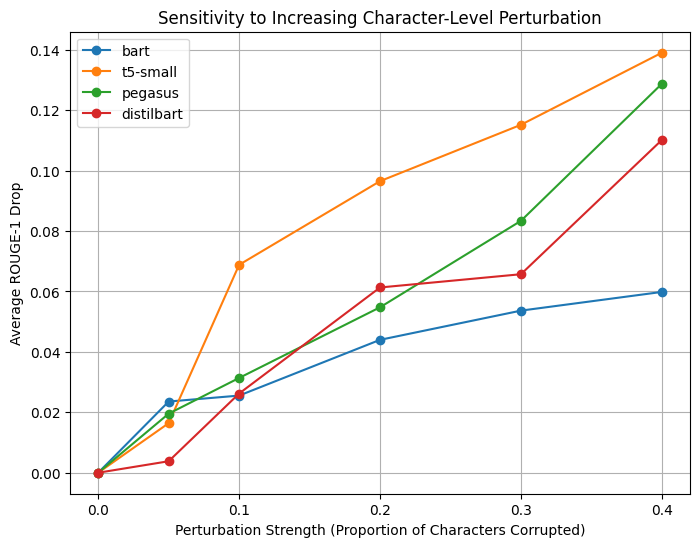

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for m in models:
    df = compute_avg_drops(all_results[m], strengths)
    plt.plot(df["strength"], df["avg_drop"], marker='o', label=m)

plt.xlabel("Perturbation Strength (Proportion of Characters Corrupted)")
plt.ylabel("Average ROUGE-1 Drop")
plt.title("Sensitivity to Increasing Character-Level Perturbation")


plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4])

plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# ================================================================
# EXPERIMENT A: SEMANTIC DRIFT CURVE UNDER HOMOGLYPH STRENGTH
# ================================================================
import random
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer, util


HOMOGLYPHS = {
    "a":"ɑ","e":"е","i":"і","o":"о","c":"ϲ","p":"р",
    "k":"κ","v":"ᴠ","n":"ո","u":"υ"
}

def apply_homoglyphs(text, strength=0.3):
    chars = list(text)
    idx = [i for i,c in enumerate(chars) if c.lower() in HOMOGLYPHS]
    k = int(len(idx)*strength)
    if k>0:
        selected = random.sample(idx, k)
        for i in selected:
            chars[i] = HOMOGLYPHS[chars[i].lower()]
    return "".join(chars)


ds = load_dataset("cnn_dailymail", "3.0.0", split="test")
samples = [x["article"].split(".")[0] for x in random.sample(list(ds), 15)]


MODEL_MAP = {
    "bart": "facebook/bart-large-cnn",
    "t5-small": "t5-small",
    "distilbart": "sshleifer/distilbart-cnn-12-6",
    "pegasus": "google/pegasus-cnn_dailymail"
}

tokenizers = {m:AutoTokenizer.from_pretrained(path) for m,path in MODEL_MAP.items()}




sbert = SentenceTransformer("all-MiniLM-L6-v2")

def sim(a,b):
    emb1 = sbert.encode(a, convert_to_tensor=True)
    emb2 = sbert.encode(b, convert_to_tensor=True)
    return float(util.cos_sim(emb1,emb2).item())

strengths = [0.0,0.1,0.2,0.3,0.4]
models = list(MODEL_MAP.keys())

semantic_drift = {m:[] for m in models}

for m in models:
    print(f"Running semantic drift test for {m}...")
    for s in strengths:
        sims=[]
        for txt in samples:
            clean_sum = generate_summary(txt, model_name=m)
            adv_txt = apply_homoglyphs(txt, s)
            adv_sum = generate_summary(adv_txt, model_name=m)
            sims.append(sim(clean_sum, adv_sum))
        semantic_drift[m].append(np.mean(sims))





KeyboardInterrupt: 

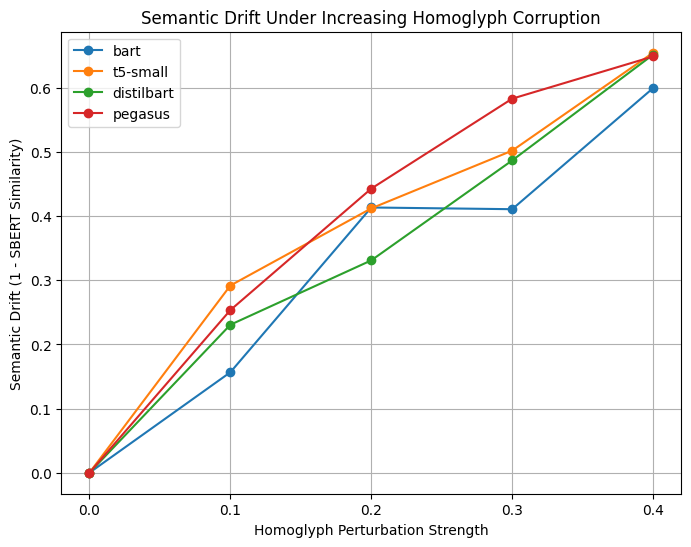

In [ ]:
# --- Plot ---
plt.figure(figsize=(8,6))
for m in models:
    plt.plot(strengths, 1-np.array(semantic_drift[m]), marker='o', label=m)
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4])
plt.xlabel("Homoglyph Perturbation Strength")
plt.ylabel("Semantic Drift (1 - SBERT Similarity)")
plt.title("Semantic Drift Under Increasing Homoglyph Corruption")
plt.legend()
plt.grid(True)
plt.show()